<a href="https://colab.research.google.com/github/jaqueantunes/IBOVESPA/blob/main/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np

# Carrega o arquivo CSV
df = pd.read_csv("Dados Históricos - Ibovespa.csv")

# Converte a coluna de data para datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Remove % da coluna Var% e converte para float
df['Var%'] = df['Var%'].str.replace(',', '.').str.replace('%', '').astype(float)

# Remove pontos e converte volume (Vol.)
def convert_volume(valor):
    if 'B' in valor:
        return float(valor.replace(',', '.').replace('B', '')) * 1_000_000_000
    elif 'M' in valor:
        return float(valor.replace(',', '.').replace('M', '')) * 1_000_000
    else:
        return float(valor.replace(',', '.'))

df['Vol.'] = df['Vol.'].apply(convert_volume)

# Converte valores numéricos (com ',' para '.')
cols_numericas = ['Último', 'Abertura', 'Máxima', 'Mínima']
for col in cols_numericas:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

# Ordena por data crescente
df = df.sort_values('Data').reset_index(drop=True)

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-06-30,118087.0,118388.0,119447.0,118087.0,13820000.0,-0.25
1,2023-07-03,119673.0,118092.0,119877.0,118092.0,8910000.0,1.34
2,2023-07-04,119076.0,119673.0,119678.0,11883.0,6560000.0,-0.50
3,2023-07-05,119549.0,119072.0,1202.0,118688.0,10960000.0,0.40
4,2023-07-06,117426.0,119548.0,119548.0,117096.0,11030000.0,-1.78


In [4]:
# Retorno percentual do dia
df['Retorno_1d'] = df['Último'].pct_change()

# Médias móveis e volatilidade
df['Retorno_3d'] = df['Último'].pct_change(3)
df['Retorno_5d'] = df['Último'].pct_change(5)
df['MM_5'] = df['Último'].rolling(5).mean()
df['Volatilidade_5d'] = df['Último'].rolling(5).std()

# Momentum
df['Momentum_5d'] = df['Último'] - df['Último'].shift(5)


In [5]:
# Criação da variável target binária
df['Target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# Remove últimas linhas com NaN
df = df.dropna().reset_index(drop=True)


In [6]:
# Define features e target
features = ['Retorno_1d', 'Retorno_3d', 'Retorno_5d', 'MM_5', 'Volatilidade_5d', 'Momentum_5d']
X = df[features]
y = df['Target']

# Separar o conjunto de teste: últimos 30 dias
X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]



In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Acurácia: 0.6
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        16
           1       0.58      0.50      0.54        14

    accuracy                           0.60        30
   macro avg       0.60      0.59      0.59        30
weighted avg       0.60      0.60      0.60        30



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:21:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


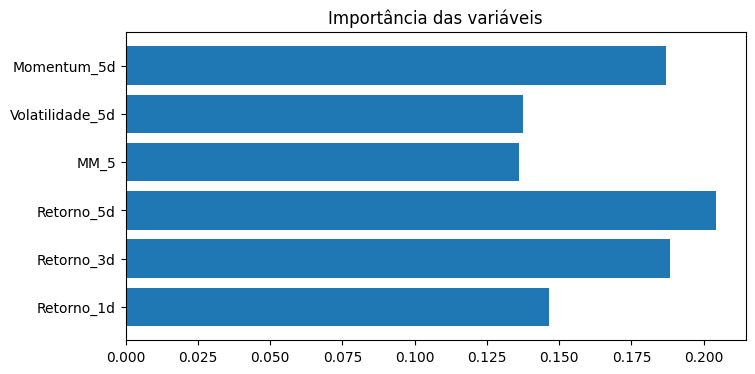

In [8]:
import matplotlib.pyplot as plt

# Importância das variáveis
importances = model.feature_importances_
plt.figure(figsize=(8,4))
plt.barh(features, importances)
plt.title("Importância das variáveis")
plt.show()


In [9]:
# Exemplo com TA-Lib (ou pandas_ta)
import pandas_ta as ta

df['rsi'] = ta.rsi(df['Último'], length=14)
df['macd'] = ta.macd(df['Último'])['MACD_12_26_9']
df['bb_upper'] = ta.bbands(df['Último'])['BBU_5_2.0']
df['bb_lower'] = ta.bbands(df['Último'])['BBL_5_2.0']


ModuleNotFoundError: No module named 'pandas_ta'

In [13]:
!pip install pandas_ta


In [17]:
# RSI (14 dias)
delta = df['Último'].diff()
ganho = delta.clip(lower=0)
perda = -delta.clip(upper=0)

media_ganho = ganho.rolling(window=14).mean()
media_perda = perda.rolling(window=14).mean()

rs = media_ganho / media_perda
df['rsi'] = 100 - (100 / (1 + rs))

# MACD (12-26)
ema12 = df['Último'].ewm(span=12, adjust=False).mean()
ema26 = df['Último'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Bandas de Bollinger (5 dias)
media_bb = df['Último'].rolling(window=5).mean()
std_bb = df['Último'].rolling(window=5).std()

df['bb_upper'] = media_bb + 2 * std_bb
df['bb_lower'] = media_bb - 2 * std_bb


In [18]:
# Criação da coluna de tendência
df['Tendência'] = df['Último'].shift(-1) > df['Último']
df['Tendência'] = df['Tendência'].map({True: 1, False: 0})


In [19]:
!pip install imbalanced-learn


In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

model_resampled = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_resampled.fit(X_train_res, y_train_res)

y_pred_res = model_resampled.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Acurácia:", accuracy_score(y_test, y_pred_res))
print(classification_report(y_test, y_pred_res))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Acurácia: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.70      0.50      0.58        14

    accuracy                           0.67        30
   macro avg       0.68      0.66      0.65        30
weighted avg       0.67      0.67      0.66        30



In [21]:
!pip install imbalanced-learn


In [22]:
# Aplicar SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# GridSearch com XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_res, y_train_res)

# Avaliação no teste
from sklearn.metrics import accuracy_score, classification_report

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Acurácia no teste:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Acurácia no teste: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        16
           1       1.00      0.21      0.35        14

    accuracy                           0.63        30
   macro avg       0.80      0.61      0.55        30
weighted avg       0.78      0.63      0.56        30



In [43]:
import yfinance as yf
dolar = yf.download("USDBRL=X", start="2022-01-01", end="2025-07-01")
dolar.head()

/tmp/ipython-input-43-1130360168.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dolar = yf.download("USDBRL=X", start="2022-01-01", end="2025-07-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,USDBRL=X,USDBRL=X,USDBRL=X,USDBRL=X,USDBRL=X
Date,,,,,
2022-01-03,5.569300,5.6707,5.4606,5.460600,0
2022-01-04,5.681200,5.7076,5.6389,5.680900,0
2022-01-05,5.676200,5.6916,5.6418,5.676000,0
2022-01-06,5.705635,5.7218,5.6828,5.707700,0
2022-01-07,5.682400,5.7069,5.6199,5.680289,0


In [29]:
import pandas as pd
import requests
from io import StringIO

# URL da série histórica da Selic diária (código 11)
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=csv&dataInicial=01/01/2022&dataFinal=01/07/2025"


# Faz o download do CSV diretamente da API
response = requests.get(url)

# Lê o conteúdo como DataFrame
df_selic = pd.read_csv(StringIO(response.text), sep=';')

# Ajusta os formatos
df_selic['data'] = pd.to_datetime(df_selic['data'], dayfirst=True)
df_selic['valor'] = df_selic['valor'].str.replace(',', '.').astype(float)

# Filtra as datas que você quer
df_selic = df_selic[df_selic['data'].between('2022-01-01', '2025-07-01')]

# Visualiza as primeiras linhas
df_selic.head()


,data,valor
0,2022-01-03,0.034749
1,2022-01-04,0.034749
2,2022-01-05,0.034749
3,2022-01-06,0.034749
4,2022-01-07,0.034749


In [37]:
df_selic.columns = df_selic.columns.str.strip().str.lower()
df_selic['data'] = pd.to_datetime(df_selic['data'], dayfirst=True)

df_ibov = df.merge(df_selic[['data', 'valor']], left_on='Data', right_on='data', how='left')
df_ibov = df.rename(columns={'valor': 'selic'})


In [44]:
df_ibov.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,rsi,macd,bb_upper,bb_lower
0,2023-06-30,118087.0,118388.0,119447.0,118087.0,13820000.0,-0.25,NaN,0.000000,NaN,NaN
1,2023-07-03,119673.0,118092.0,119877.0,118092.0,8910000.0,1.34,NaN,126.518519,NaN,NaN
2,2023-07-04,119076.0,119673.0,119678.0,11883.0,6560000.0,-0.50,NaN,176.576976,NaN,NaN
3,2023-07-05,119549.0,119072.0,1202.0,118688.0,10960000.0,0.40,NaN,251.516485,NaN,NaN
4,2023-07-06,117426.0,119548.0,119548.0,117096.0,11030000.0,-1.78,NaN,138.007366,120708.583004,116815.816996


In [49]:
# Cria a variável alvo: 1 se subir no dia seguinte, 0 se cair
df['target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# Remove a última linha, pois não tem target
df = df.dropna()



In [51]:
# Calcula os retornos percentuais com base na coluna 'Último'
df['Retorno_1d'] = df['Último'].pct_change(periods=1)
df['Retorno_3d'] = df['Último'].pct_change(periods=3)
df['Retorno_5d'] = df['Último'].pct_change(periods=5)

# Remove linhas com valores nulos (ocorre no começo por causa do shift)
df = df.dropna().reset_index(drop=True)


In [52]:
X = df[['Último', 'Retorno_1d', 'Retorno_3d', 'Retorno_5d']]
y = df['target']



In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cria e treina o modelo
modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X_train, y_train)

# Faz previsões
y_pred = modelo.predict(X_test)

# Avalia o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Acurácia: 0.5724137931034483

Matriz de Confusão:
 [[58 13]
 [49 25]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.54      0.82      0.65        71
           1       0.66      0.34      0.45        74

    accuracy                           0.57       145
   macro avg       0.60      0.58      0.55       145
weighted avg       0.60      0.57      0.55       145



In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))


Acurácia: 0.5379310344827586

Matriz de Confusão:
 [[46 25]
 [42 32]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.52      0.65      0.58        71
           1       0.56      0.43      0.49        74

    accuracy                           0.54       145
   macro avg       0.54      0.54      0.53       145
weighted avg       0.54      0.54      0.53       145



In [56]:
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)


In [57]:
import numpy as np

# Cria colunas de retorno logarítmico
df['Retorno_1d'] = np.log(df['Último'] / df['Último'].shift(1))
df['Retorno_3d'] = np.log(df['Último'] / df['Último'].shift(3))
df['Retorno_5d'] = np.log(df['Último'] / df['Último'].shift(5))

# Remove linhas com valores NaN gerados pelo shift
df = df.dropna()


In [58]:
# Seleciona as features e o alvo
X = df[['Último', 'Retorno_1d', 'Retorno_3d', 'Retorno_5d']]
y = df['target']

# Divide em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Treina o modelo
modelo = DecisionTreeClassifier(max_depth=9, random_state=42)
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Avaliação
print("Decision Tree - Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Decision Tree - Acurácia: 0.6458333333333334

Matriz de Confusão:
 [[36  9]
 [25 26]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.59      0.80      0.68        45
           1       0.74      0.51      0.60        51

    accuracy                           0.65        96
   macro avg       0.67      0.65      0.64        96
weighted avg       0.67      0.65      0.64        96

